# CBIR con HARRIS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from google.colab.patches import cv2_imshow

Definimos las siguiente funciones para mostrar los resultados

In [4]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=reverse)[:n] #Ordeno y me quedo con los 5 más parecidos
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)


    plt.show()

## Almacenamos los paths de todas las imagenes

In [5]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601",
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325",
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]

In [6]:
len(carpetas)

20

In [7]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'/content/drive/MyDrive/dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
            # images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths


In [8]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

## Como funciona HARRIS

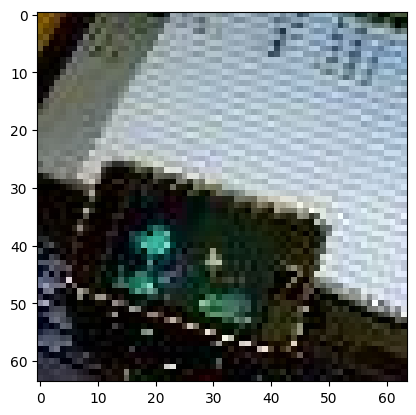

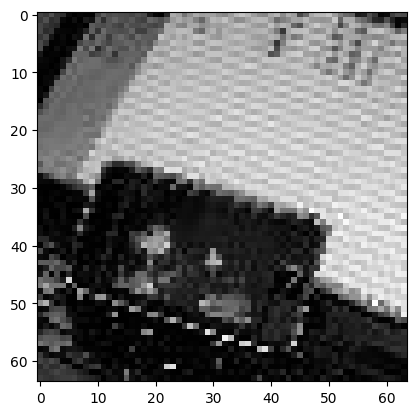

In [9]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.show()
gray_im = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im, cmap='gray')
plt.show()

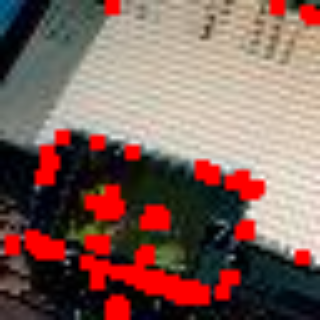

In [10]:
gray_im = np.float32(gray_im)
dst = cv2.cornerHarris(gray_im,2,3,0.04)

# Dilatar las esquinas para una mejor visualización
dst = cv2.dilate(dst, None)


# Resaltar las esquinas en la imagen en color
new_img[dst > 0.1 * dst.max()] = [0, 0, 255]  # Color rojo para las esquinas

larger_image = cv2.resize(new_img, None, fx=5, fy=5)

# Mostrar la imagen con esquinas resaltadas
cv2_imshow(larger_image)
#cv2.imshow('Esquinas Harris', result_image)


In [140]:
dst

array([[ 1.8199664e+05,  1.8199664e+05,  2.0047831e+06, ...,
         5.2844462e+05,  4.1207594e+05,  5.6552369e+05],
       [ 1.8199664e+05,  1.8199664e+05,  2.0047831e+06, ...,
         5.2844462e+05,  4.1207594e+05,  5.6552369e+05],
       [ 6.2181422e+04,  6.2181422e+04,  1.3855055e+06, ...,
         4.6983625e+05,  2.4128675e+05,  3.9593244e+05],
       ...,
       [ 8.1929895e+06,  8.1929895e+06,  5.6954450e+06, ...,
        -3.3955835e+02,  2.5237236e+04,  6.1988141e+04],
       [ 1.2093236e+07,  1.2093236e+07,  4.0901505e+06, ...,
         2.5668734e+04,  4.1745569e+05,  1.7911438e+06],
       [ 1.4357469e+07,  1.4357469e+07,  5.3241480e+06, ...,
         3.2671910e+04, -1.8622231e+05,  9.9390400e+05]], dtype=float32)

La función devuelve una matriz de valores de esquina que indica la medida de la respuesta de Harris en cada píxel de la imagen de entrada.

La matriz devuelta por cv2.cornerHarris() tendrá el mismo tamaño que la imagen de entrada y contendrá valores que representan la medida de la esquina en cada píxel. Los valores más altos en esta matriz indican las regiones de la imagen donde se encuentran las esquinas.

En este caso devuelve una matriz de 64 valores.

## Aplicamos el detector de esquinas HARRIS a todas nuestras imagenes

In [12]:
if os.path.exists('HARRIS_descriptors.npy'):
    corners = np.load('HARRIS_descriptors.npy')
else:

    corners = np.empty((0,66))
    for idx in images_path:
        gray_im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2GRAY)
        gray_im = np.float32(gray_im)
        dst = cv2.cornerHarris(gray_im,2,3,0.04)
        corner_arr = np.array(dst)
        if np.any(corner_arr):
            corner_arr = np.insert(corner_arr, 0, idx[1], axis=1)
            corner_arr = np.insert(corner_arr, 0, idx[0], axis=1)
            corners =  np.vstack([corners, corner_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen
    np.save('HARRIS_descriptors', corners)


In [161]:
len(corners[0])


KeyError: ignored

In [14]:
corners[65]

array([ 4.48708100e+06,  1.00000000e+00,  5.00000000e-01,  5.00000000e-01,
        4.11875010e-01,  6.97656274e-02,  2.74414062e-01,  3.87851566e-01,
        7.44531304e-02,  3.53421879e+00,  9.44921875e+00,  5.88812542e+00,
        6.46777344e+00,  1.28664455e+01,  6.96019554e+00, -2.11562157e-01,
        1.11875057e-01,  6.31566429e+00,  2.64062500e+00,  1.59124994e+00,
        4.11875010e-01,  6.97656274e-02,  2.74414062e-01,  3.87851566e-01,
        7.44531304e-02,  6.97656274e-02,  1.22656301e-02,  1.82031263e-02,
        6.95703179e-02,  6.91015646e-02,  1.68515623e-01,  3.41562510e-01,
        1.89101562e-01,  1.43593758e-01,  1.59999996e-01,  2.03281254e-01,
        6.95703179e-02,  6.91015646e-02,  1.68515623e-01,  3.41562510e-01,
        1.89101562e-01,  1.91562504e-01,  2.79687494e-02,  6.65976584e-01,
        4.18203115e-01, -1.04027343e+00,  1.41015053e-02,  5.23789167e-01,
       -1.59117174e+00,  5.16957045e+00,  3.57905884e+01,  4.21422485e+02,
        6.95777222e+02,  

## Entrenamos KNN

In [15]:
n_neighbors = 10000
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

descriptors_train = corners[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean', n_neighbors=10000)

In [16]:
len(descriptors_train)

128000

## Obtenemos las imagenes más similares a una nueva imagen

In [31]:
counts = {}
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)

gray_im_new = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
new_corners = cv2.cornerHarris(gray_im_new,2,3,0.04)

for descriptor in new_corners:
    descriptor = descriptor.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor)
    for idx in indice[0]:
        carpeta = str(int(corners[idx,0]))
        num_img = str(int(corners[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1

In [32]:
len(counts)

926

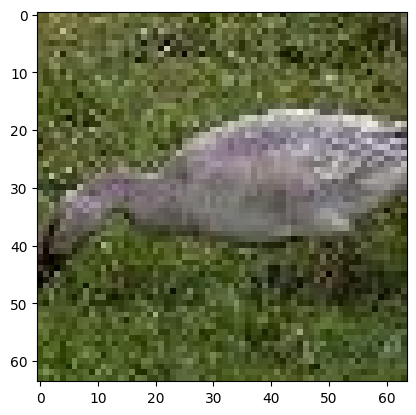

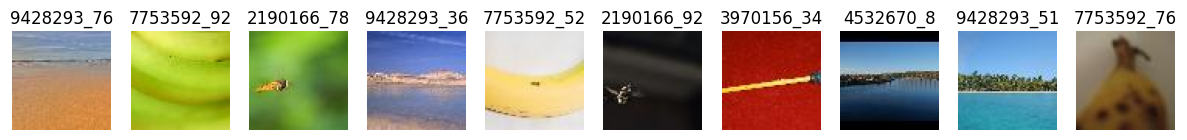

In [33]:
plt.imshow(new_img)
idx_similar = get_n_similar(10, counts, 1)
display_n_similar(idx_similar, 10)

# CBIR CON FAST

In [20]:
import tensorflow as tf

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

## Almacenamos los paths de todas las imagenes

In [21]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601",
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325",
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]

In [22]:
len(carpetas)

20

In [162]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'/content/drive/MyDrive/dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
            # images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [163]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

## Como funciona FAST

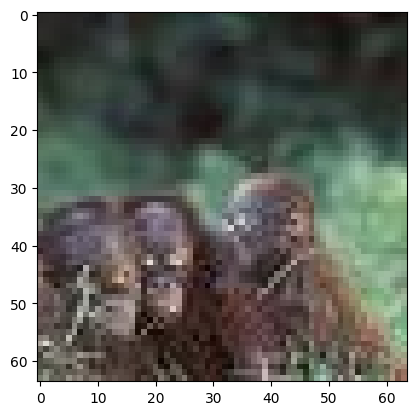

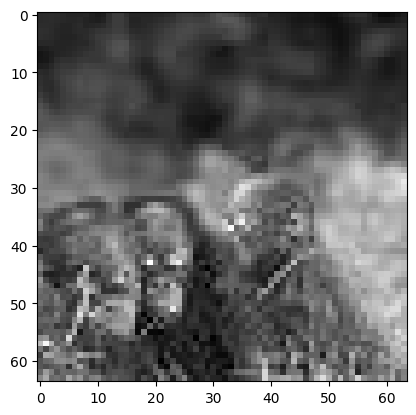

In [164]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.show()
gray_im = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im, cmap='gray')
plt.show()

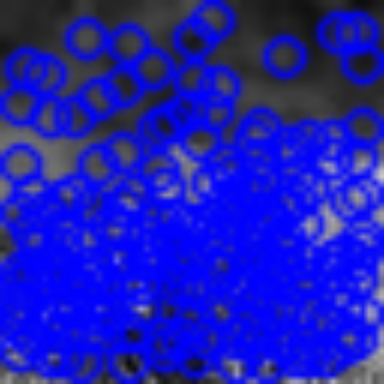

In [165]:
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(gray_im,None)
img2 = cv2.drawKeypoints(gray_im, kp, None, color=(255,0,0))
cv2_imshow(cv2.resize(img2, None, fx=6, fy=6))


In [166]:
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=64)

# Detecta keypoints en ambas imágenes con FAST
_, descriptors = brief.compute(gray_im, kp)

In [168]:
descriptors.shape

(1, 64)

In [167]:
len(descriptors)

1

In [114]:
if os.path.exists('./npy_mat/FAST_descriptors.npy'):
    descriptors = np.load('./npy_mat/FAST_descriptors.npy')
else:

    fast = cv2.FastFeatureDetector_create()
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=64)
    descriptors = np.empty((0,66))
    for idx in images_path:
        gray_im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2GRAY)
        kp = fast.detect(gray_im,None)
        _, descriptor = brief.compute(gray_im, kp)
        descriptors_arr = np.array(descriptor)
        if np.any(descriptors_arr):
            descriptors_arr = np.insert(descriptors_arr, 0, idx[1], axis=1)
            descriptors_arr = np.insert(descriptors_arr, 0, idx[0], axis=1)
            descriptors =  np.vstack([descriptors, descriptors_arr])
    np.save('FAST_descriptors', descriptors)
descriptors.shape

(8581, 66)

In [139]:
descriptors[65]

array([169.,  14., 177., 168.,  86., 137.,  20., 232.,  68.,  35., 182.,
       250.,  81.,  51.,  78.,  65.,  95., 245., 236.,  65., 156., 163.,
       209.,  64., 208., 213.,  18., 207.,  71.,  44., 197., 243., 216.,
        15., 231., 235., 242.,  29.,  21., 165., 103., 114., 158.,  16.,
       197., 107.,  93.,  66., 110., 187., 188., 104., 187.,  94., 204.,
       198.,  22., 104., 205., 146., 225.,  34.,  81., 173.,  19., 215.])

## Entrenamos KNN

In [128]:
n_neighbors = 50
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean', n_neighbors=50)

In [126]:
len(descriptors_train)

8581

## Obtenemos las imagenes más similares a una nueva imagen

In [129]:
counts = {}
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)

fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(gray_im,None)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=64)

# Detecta keypoints en ambas imágenes con FAST
_, new_descriptors = brief.compute(gray_im, kp)
for descriptor in new_descriptors:
    descriptor = descriptor.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor, n_neighbors=n_neighbors)
    for idx in indice[0]:
        carpeta = str(int(descriptors[idx,0]))
        num_img = str(int(descriptors[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1

In [130]:
len(counts)

127

KeyError: ignored

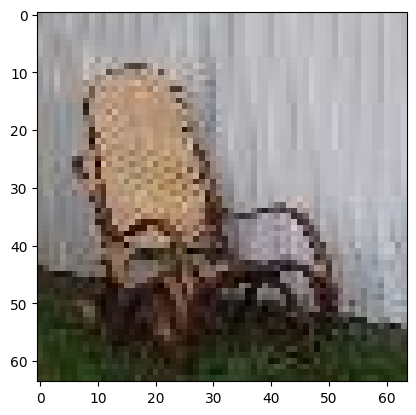

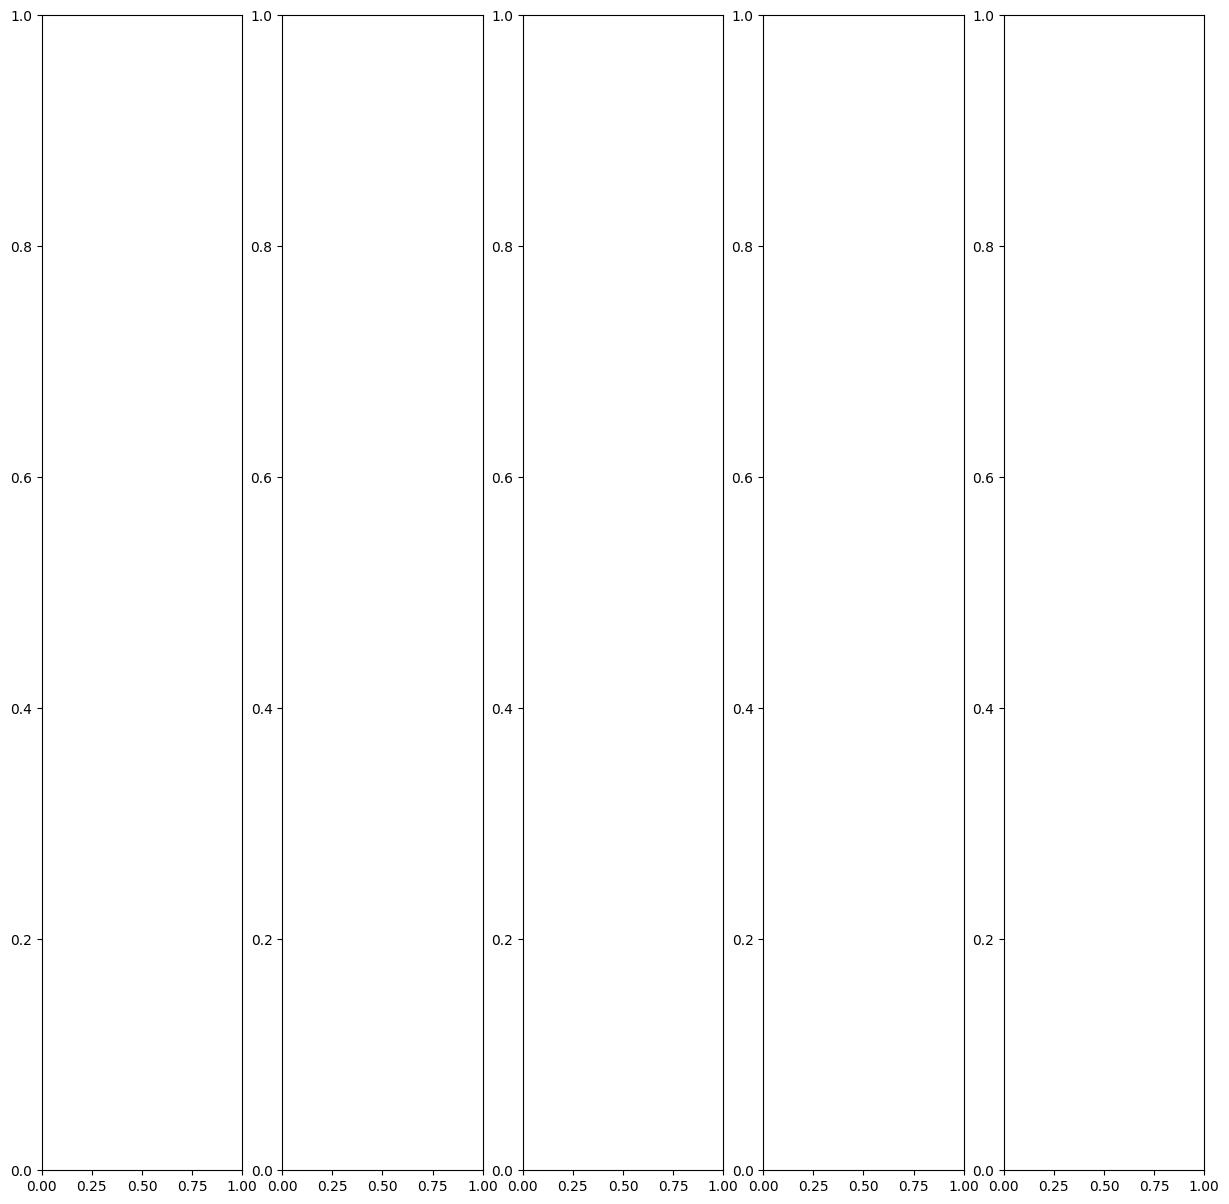

In [133]:
plt.imshow(new_img)
idx_similar = get_n_similar(5, counts, 1)
display_n_similar(idx_similar, 5)

# CBIR con ORB


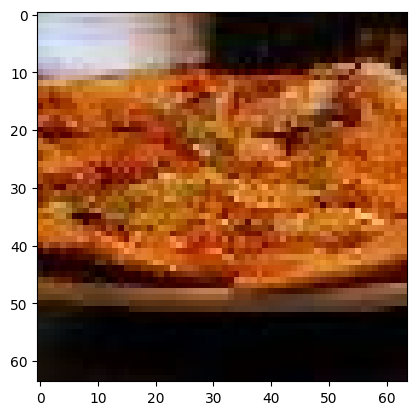

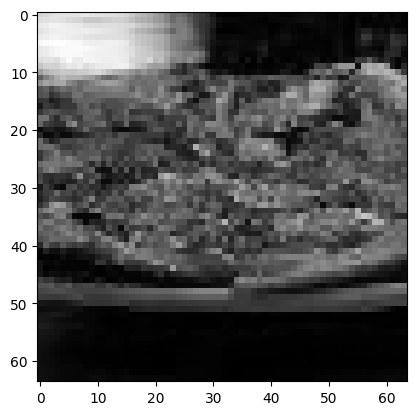

In [153]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.show()
gray_im = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im, cmap='gray')
plt.show()

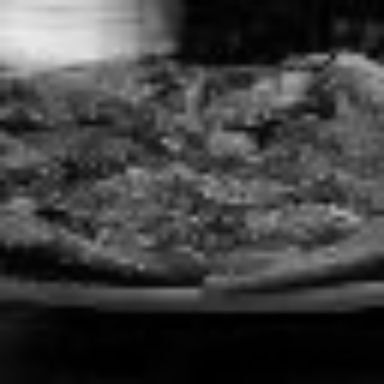

In [154]:
# Inicializa el detector ORB
orb = cv2.ORB_create()

# Detecta keypoints con ORB
kp = orb.detect(new_img, None)
kp, des = orb.compute(new_img, kp)
img2 = cv2.drawKeypoints(gray_im, kp, None, color=(0,255,0))
cv2_imshow(cv2.resize(img2, None, fx=6, fy=6))





In [155]:
des.shape

AttributeError: ignored